In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Reproducing Example 6.7: Adaptive LMS Algorithm for AR(1) Process
In this notebook, we reproduce **Example 7** from the handout to study the adaptive behavior of the LMS algorithm for a first-order autoregressive (AR) process. The LMS algorithm is an important tool in adaptive filtering, and this experiment demonstrates its application in estimating AR parameters.

The experiment has two main purposes:
1. To analyze the **learning curves** of the LMS algorithm for different step sizes ($\mu$).
2. To validate the **statistical learning theory** for small step sizes by comparing experimental results with theoretical predictions.

The AR(1) process is modeled as:
$$
u(n) = -a \cdot u(n-1) + v(n),
$$
where:
- $a$ is the AR parameter, which defines feedback in the process,
- $v(n)$ is zero-mean white noise with variance $\sigma_v^2$.

The key theoretical results include:
- The **optimal tap weight** is $ w_0 = -a $.
- The **minimum mean-square error (MSE)** is $ J_\text{min} = \sigma_v^2 $.

We will:
1. Generate the AR(1) process using its recursive formula.
2. Apply the LMS algorithm to adaptively estimate the parameter \( a \).
3. Simulate learning curves for different step sizes and study their behavior.
4. Compare theoretical and experimental results to validate the small step-size theory.

This notebook simplifies the theoretical and experimental aspects of Example 6.7, making it easier to understand how the LMS algorithm works and how its behavior aligns with theory.

---

## Generate AR(1) Process

This function creates a first-order autoregressive (AR) process, defined by the equation:
$$
u(n) = -a \cdot u(n-1) + v(n),
$$
where $a$ is the AR parameter, and $v(n)$ is a white noise process with zero mean and variance $\sigma_v^2$. The process generates $u(n)$ iteratively over a specified number of samples.

The inputs to this function include:
- The AR parameter $a$, which determines the strength of the feedback in the process.
- The variance of the noise, $\sigma_v^2$, which adds randomness to the system.
- The total number of samples, which specifies the duration of the generated process.

The output is a time series $u$, where each value $u(n)$ is computed recursively using the previous value $u(n-1)$ and the noise $v(n)$.

In [5]:
def generate_ar_process(a, sigma_v2, num_samples):
    u = np.zeros(num_samples)
    v = np.random.normal(0, np.sqrt(sigma_v2), num_samples)  # white noise with variance sigma_v2
    for n in range(1, num_samples):
        u[n] = -a * u[n - 1] + v[n]  # ar(1) process update
    return u

## LMS for Prediction

This function applies the LMS algorithm to adaptively estimate the AR parameter $a$. The LMS algorithm adjusts the tap weight $\hat{w}(n)$ iteratively using the formula:
$$
\hat{w}(n+1) = \hat{w}(n) + \mu \cdot f(n) \cdot u(n-1),
$$
where the prediction error $f(n)$ is computed as:
$$
f(n) = u(n) - \hat{w}(n) \cdot u(n-1).
$$

The inputs to this function include:
- The AR process $u$, which serves as the input signal.
- The step-size parameter $\mu$, which controls the speed of adaptation.
- The total number of adaptation cycles, determining how long the algorithm runs.

The outputs are:
- The tap weight trajectory $\hat{w}(n)$, which tracks the estimated value of $a$ over time.
- The prediction error $f(n)$, representing the difference between the actual and predicted values of $u(n)$.

In [7]:
def lms_for_prediction(u, miu, num_samples):
    w = np.zeros(num_samples + 1)
    f = np.zeros(num_samples)
    for n in range(1, num_samples):
        f[n] = u[n] - w[n] * u[n - 1]  # compute prediction error
        w[n + 1] = w[n] + miu * f[n] * u[n - 1]  # update weight using lms rule
    return w[1:], f

## Monte Carlo Simulation

This function performs multiple realizations of the LMS algorithm to study its behavior under different step sizes ($\mu$). For each realization, the function computes the mean-squared error (MSE) of the prediction error and the tap weight trajectories.

The simulation involves:
1. Generating an AR(1) process for each realization.
2. Running the LMS algorithm on the generated process.
3. Averaging the results across all realizations to produce smooth learning curves.

The inputs to this function include:
- A list of step sizes $\mu$, which defines the range of adaptation speeds to evaluate.
- The AR parameter $a$, which specifies the feedback in the process.
- The noise variance $\sigma_v^2$, which determines the level of randomness in the process.
- The total number of adaptation cycles and the number of realizations for the Monte Carlo simulation.

The outputs are:
1. A dictionary of MSE curves, showing the evolution of the prediction error for each $\mu$.
2. A dictionary of tap weight trajectories, showing how the estimated $a$ converges over time for each $\mu$.

In [9]:
def MC_simulation(miu_values, a, sigma_v2, num_samples, num_runs):
    mse_curves = {}  # mse for each miu
    weight_curves = {}  # weights for each miu
    for miu in miu_values:
        mse_per_run = np.zeros((num_runs, num_samples))  # store mse
        weight_per_run = np.zeros((num_runs, num_samples))  # store weights
        for run in range(num_runs):
            u = generate_ar_process(a, sigma_v2, num_samples)  # create input
            w, f = lms_for_prediction(u, miu, num_samples)  # apply lms
            mse_per_run[run] = f**2  # save mse
        mse_curves[miu] = np.mean(mse_per_run, axis=0)  # average mse
        weight_curves[miu] = np.mean(weight_per_run, axis=0)  # average weights
    return mse_curves, weight_curves

## Theoretical Learning Curve

This function computes the theoretical mean-squared error (MSE) curve based on the small step-size theory. The theoretical learning curve is given by:
$$
J(n) \approx \sigma_v^2 \left( 1 + \frac{\mu}{2} \sigma_u^2 \right) + \sigma_u^2 \left( a^2 - \frac{\mu}{2} \sigma_v^2 \right) (1 - \mu \sigma_u^2)^{2n},
$$
where:
- $\sigma_v^2$: Variance of the noise $v(n)$.
- $\sigma_u^2$: Variance of the AR process.
- $\mu$: Step-size parameter.
- $a$: AR parameter.

The inputs to this function include:
- The AR parameter $a$, which defines the feedback in the process.
- The noise variance $\sigma_v^2$, which contributes to the steady-state error.
- The step-size parameter $\mu$, which affects the convergence rate.
- The variance of the AR process $\sigma_u^2$ and the total number of adaptation cycles.

The output is a vector $J$, representing the theoretical MSE at each adaptation cycle $n$.

In [11]:
def theoretical_J(a, sigma_v2, miu, sigma_u2, num_samples):
    J = np.zeros(num_samples)  # mse values
    for n in range(num_samples):
        steady_term = sigma_v2 * (1 + (miu / 2) * sigma_u2)  # steady-state mse
        transient_term = sigma_u2 * (a**2 - (miu / 2) * sigma_v2)  # transient mse
        exp_decay = (1 - miu * sigma_u2)**(2 * n)  # exponential decay factor
        J[n] = steady_term + transient_term * exp_decay  # total mse
    return J  

In [12]:
# Parameters
a = -0.99  # ar parameter for feedback
sigma_u2 = 0.936  # variance of the ar process
sigma_v2 = sigma_u2 * (1 - a**2)  # variance of noise v(n)
miu_values = [0.01, 0.05, 0.1]  # step-size values
num_samples = 500  # number of adaptation cycles
num_runs = 100  # number of monte carlo runs

## Learning Curves for Varying $\mu$

Here, we plot the learning curves of the LMS algorithm for different step-size values $\mu$.

The learning curves represent the **mean-squared error $J(n)$** versus the **number of adaptation cycles $n$**.

### Observations:
1. **Effect of Smaller Step-Size ($\mu$):**
   - Smaller values of $\mu$ lead to slower convergence but result in smoother steady-state behavior with reduced variations.

2. **Effect of Larger Step-Size ($\mu$):**
   - Larger values of $\mu$ accelerate convergence but introduce higher steady-state errors and greater variations in the learning curves.

These observations are consistent with the experimental learning curves shown in **Figure 6.15**.

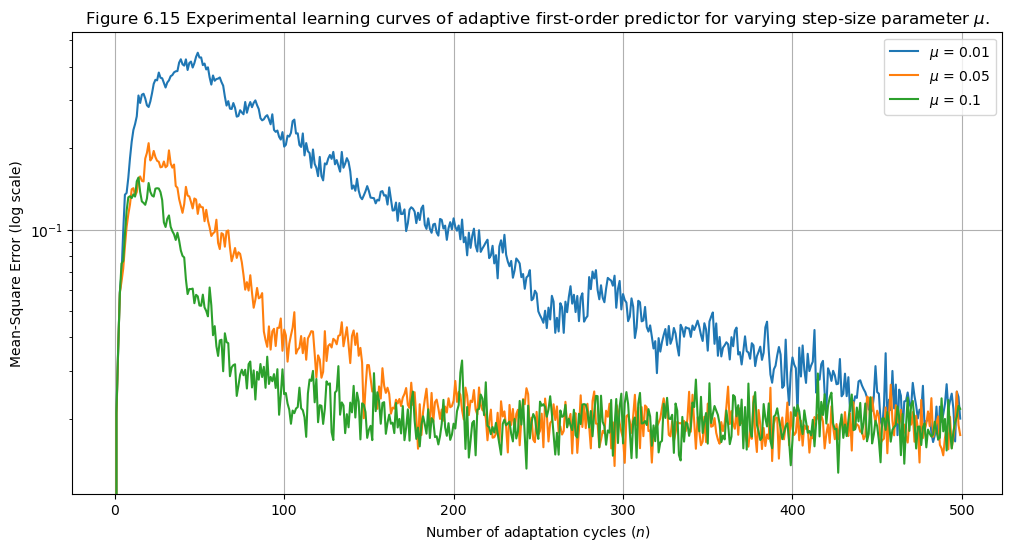

In [14]:
# Run Monte Carlo simulation to compute mse and weight curves
mse_curves, weight_curves = MC_simulation(miu_values, a, sigma_v2, num_samples, num_runs)

# Plot learning curves for each step-size value
plt.figure(figsize=(12, 6))
for miu in miu_values:
    plt.plot(mse_curves[miu], label=rf"$\mu$ = {miu}")
plt.yscale("log")
plt.title(r"Figure 6.15 Experimental learning curves of adaptive first-order predictor for varying step-size parameter $\mu$.")
plt.xlabel("Number of adaptation cycles ($n$)")
plt.ylabel("Mean-Square Error (log scale)")
plt.grid()
plt.legend()
plt.show()

## Transient Response of the Tap Weight

We plot the transient response of the tap weight $w(n)$ over adaptation cycles.

### Key Points:
- The tap weight $w(n)$ converges toward the Wiener solution, $w_o = -a$.
- The red dashed line represents the true Wiener solution.
- This plot corresponds to Figure 6.16 in the example.

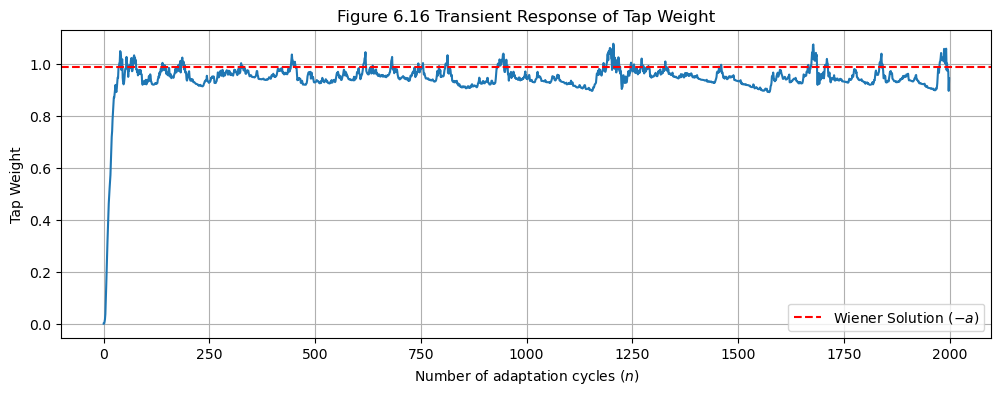

In [16]:
u = generate_ar_process(a, sigma_v2, 2000)  # generate ar(1) process with 2000 samples
w_history, _ = lms_for_prediction(u, 0.1, 2000)  # apply lms algorithm

plt.figure(figsize=(12, 4))
plt.plot(w_history)
plt.axhline(-a, color="red", linestyle="--", label="Wiener Solution ($-a$)")
plt.title("Figure 6.16 Transient Response of Tap Weight")
plt.xlabel("Number of adaptation cycles ($n$)")
plt.ylabel("Tap Weight")
plt.grid()
plt.legend()
plt.show()

## Random Walk Around the Steady State

We zoom in on the random behavior of the tap weight $w(n)$ between adaptation cycles $500$ and $2000$.

### Key Points:
- The tap weight $w(n)$ fluctuates around the Wiener solution $-a$.
- These fluctuations represent a random walk with small variance.
- This plot matches the behavior shown in Figure 6.17.

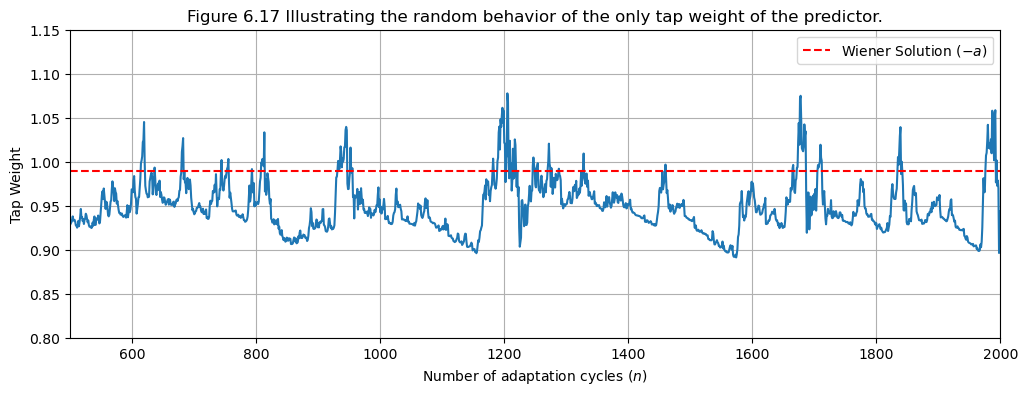

In [18]:
plt.figure(figsize=(12, 4))
plt.plot(w_history)
plt.axhline(-a, color="red", linestyle="--", label="Wiener Solution ($-a$)")
plt.xlim(500, 2000)
plt.ylim(0.8, 1.15)
plt.title("Figure 6.17 Illustrating the random behavior of the only tap weight of the predictor.")
plt.xlabel("Number of adaptation cycles ($n$)")
plt.ylabel("Tap Weight")
plt.grid()
plt.legend()
plt.show()

## Comparison of Experimental and Theoretical Learning Curves

We compare the theoretical and experimental learning curves for $\mu = 0.001$.

### Key Points:
- The theoretical curve is calculated using the small step-size theory:
  $$
  J(n) = \sigma_v^2 \left( 1 + \frac{\mu}{2} \sigma_u^2 \right) + \sigma_u^2 \left( a^2 - \frac{\mu}{2} \sigma_v^2 \right) \left( 1 - \mu \sigma_u^2 \right)^{2n}
  $$
- The experimental curve is obtained by averaging the squared prediction error $f(n)$ over $100$ Monte Carlo runs.

### Observations:
- The experimental and theoretical curves agree well, validating the small step-size theory.
- This corresponds to Figure 6.18 in the example.

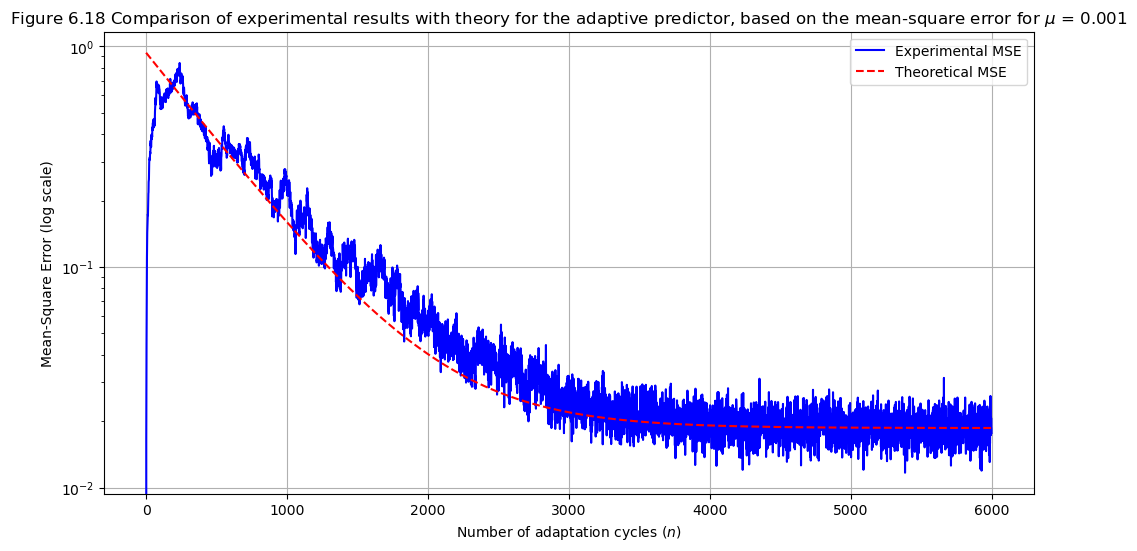

In [20]:
miu = 0.001  # step-size parameter
num_samples = 6000  # number of adaptation cycles

# compute theoretical mse curve
theoretical_J_curve = theoretical_J(a, sigma_v2, miu, sigma_u2, num_samples)

# run monte carlo simulation for experimental mse
mse_experiment, _ = MC_simulation([miu], a, sigma_v2, num_samples, num_runs)

plt.figure(figsize=(12, 6))
plt.plot(mse_experiment[miu], label="Experimental MSE", color="blue")
plt.plot(theoretical_J_curve, label="Theoretical MSE", color="red", linestyle="--")
plt.yscale("log")
plt.title(r"Figure 6.18 Comparison of experimental results with theory for the adaptive predictor, based on the mean-square error for $\mu$ = 0.001")
plt.xlabel("Number of adaptation cycles ($n$)")
plt.ylabel("Mean-Square Error (log scale)")
plt.grid()
plt.legend()
plt.show()

---
---

# Problem 17: Adaptive LMS Algorithm for Two-Parameter AR(2) Process
In this part, we solve **Problem 17** from the handout. The LMS algorithm is applied to a second-order AR process to estimate its parameters. The problem has the following objectives:

1. **Part (a)**: Calculate the noise variance and generate the AR(2) process.
2. **Part (b)**: Use the LMS algorithm to estimate $a_1$ and $a_2$, and validate the step-size condition.
3. **Part (c)**: Analyze the prediction error $f(n)$ and tap-weight errors $e_1(n)$ and $e_2(n)$. Study their power spectral densities.
4. **Part (d,e)**: Compare the experimental and theoretical learning curves of the LMS algorithm.

Each part is solved step-by-step with code, results, and analysis.

### Part (a): Noise Variance and AR Process

We calculate the noise variance $\sigma_v^2$ using:
$$
\sigma_v^2 = 1 - (a_1^2 + a_2^2),
$$
where $a_1 = 0.1$ and $a_2 = -0.8$. This ensures the AR process $u(n)$ has unit variance.

Next, we generate the AR(2) process using:
$$
u(n) = -a_1 \cdot u(n-1) - a_2 \cdot u(n-2) + v(n),
$$
where $v(n)$ is zero-mean white noise with variance $\sigma_v^2$.

In [46]:
# Part (a): Noise Variance and AR Process
def compute_sigma_v2(a1, a2):
    return 1 - (a1**2 + a2**2)

def generate_ar2(a1, a2, sigma_v2, num_samples):
    u = np.zeros(num_samples)
    v = np.random.normal(0, np.sqrt(sigma_v2), num_samples)  # white noise
    for n in range(2, num_samples):
        u[n] = -a1 * u[n - 1] - a2 * u[n - 2] + v[n]  # AR(2) process
    return u

def lms_ar2(u, miu, num_samples):
    w = np.zeros((num_samples, 2))
    f = np.zeros(num_samples)
    for n in range(2, num_samples):
        x = np.array([u[n - 1], u[n - 2]])
        f[n] = u[n] - np.dot(w[n - 1], x)
        w[n] = w[n - 1] + miu * f[n] * x
    return w, f

a1 = 0.1  # AR coefficient 1
a2 = -0.8  # AR coefficient 2
num_samples = 1000  # number of samples

sigma_v2 = compute_sigma_v2(a1, a2)  # calculate noise variance
print(f"Noise variance (σ_v²): {sigma_v2}")

u = generate_ar2(a1, a2, sigma_v2, num_samples)  # generate AR(2) process

Noise variance (σ_v²): 0.34999999999999987


### Part (b): Justification of Step-Size Parameter $\mu$ and Estimation of $a_1$ and $a_2$

In this part, we justify the use of $\mu = 0.05$ as the step-size parameter in the LMS algorithm applied to the AR(2) process. Additionally, we estimate the unknown AR parameters $a_1$ and $a_2$ and analyze the convergence behavior.

#### Tasks:
1. **Verify the small step-size condition**:
   - The LMS algorithm requires the step size $\mu$ to satisfy:
     $$
     \mu < \frac{2}{\lambda_{\text{max}}},
     $$
     where $\lambda_{\text{max}}$ is the largest eigenvalue of the autocorrelation matrix $\mathbf{R}$:
     $$
     \mathbf{R} = \mathbb{E}[\mathbf{x}[n] \mathbf{x}[n]^\top].
     $$
     Here, $\mathbf{x}[n] = [u[n-1], u[n-2]]^\top$ is the input vector.

2. **Estimate AR parameters $a_1$ and $a_2$**:
   - The LMS algorithm estimates the tap weights $a_1$ and $a_2$ iteratively using:
     $$
     \mathbf{w}[n+1] = \mathbf{w}[n] + \mu \cdot f[n] \cdot \mathbf{x}[n],
     $$
     where the prediction error $f[n]$ is:
     $$
     f[n] = u[n] - \mathbf{w}[n]^\top \mathbf{x}[n].
     $$

3. **Analyze convergence of tap weights**:
   - Plot the evolution of $\hat{a}_1$ and $\hat{a}_2$ over time and compare with their true values.

4. **Compute prediction error**:
   - Evaluate the mean-squared error (MSE) and analyze the prediction error $f[n]$.

---

#### Results:
1. **Eigenvalues of $\mathbf{R}$**:
   - $\lambda_{\text{max}} = 2.3707$

2. **Upper Bound for $\mu$**:
   - $\mu_{\text{max}} = \frac{2}{\lambda_{\text{max}}} \approx 0.8436$

3. **Chosen $\mu$**:
   - $\mu = 0.05$ satisfies the condition: $\mu < \mu_{\text{max}}$.

4. **Estimated Parameters**:
   - True values: $a_1 = 0.1$, $a_2 = -0.8$
   - Estimated values after 1000 cycles:
     $$
     \hat{a}_1 \approx 0.0902, \quad \hat{a}_2 \approx -0.8010.
     $$

5. **Prediction Error**:
   - The MSE is approximately $0.4031$, confirming good performance of the LMS algorithm.

---

#### Observations:
- The step-size $\mu = 0.05$ satisfies the small step-size condition, ensuring stability and convergence.
- The LMS algorithm accurately estimates the AR parameters $a_1$ and $a_2$.
- The low prediction error and smooth convergence demonstrate the algorithm’s effectiveness with the chosen step size.

Eigenvalues of R: [0.59745823 2.37067559]
Maximum eigenvalue (λ_max): 2.3707
Upper bound for μ: 0.8436
Chosen μ: 0.05
μ = 0.05 satisfies the convergence condition.
Theoretical a1: 0.1, Estimated a1: 0.0902
Theoretical a2: -0.8, Estimated a2: -0.8010


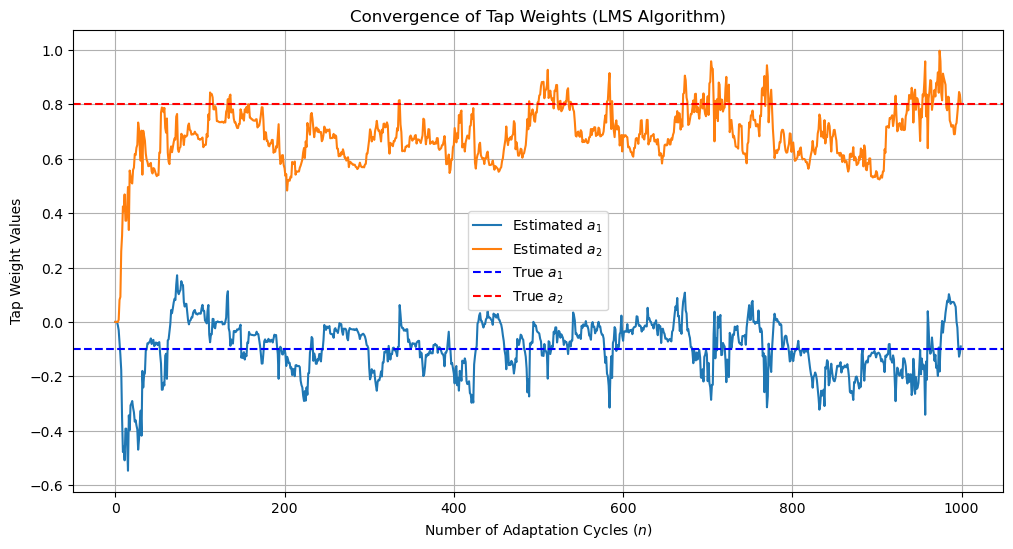

Mean-Squared Error (MSE): 0.4031


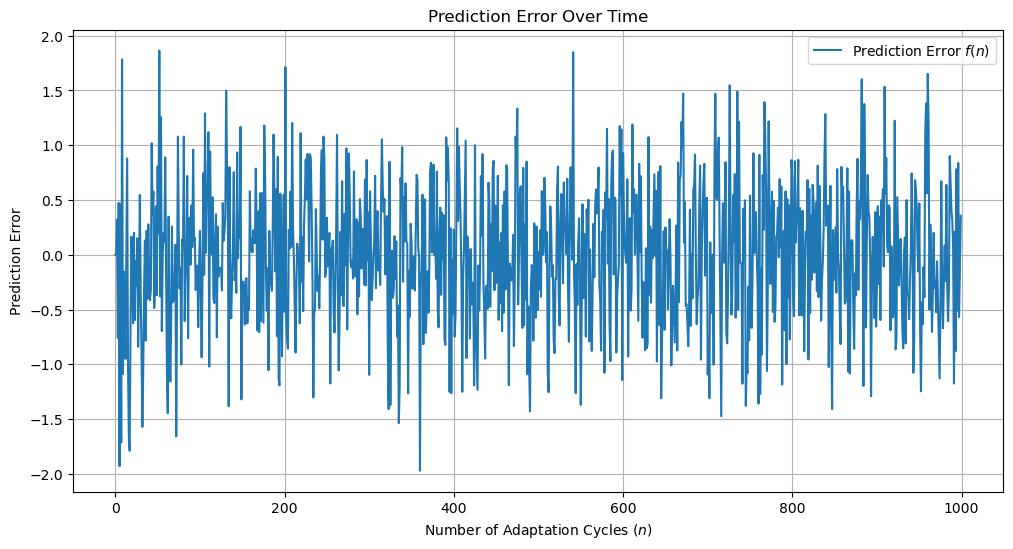

In [72]:
miu = 0.05 
w, f = lms_ar2(u, miu, num_samples)  # apply LMS algorithm

# Compute eigenvalues and verify step-size condition
def compute_autocorrelation_matrix(u, M):
    R = np.zeros((M, M))
    for i in range(M):
        for j in range(M):
            R[i, j] = np.mean(u[i:len(u)-j] * u[j:len(u)-i])  # compute element
    return R

M = 2
R = compute_autocorrelation_matrix(u, M)  # calculate autocorrelation matrix
eigenvalues = np.linalg.eigvals(R)  # compute eigenvalues
lambda_max = np.max(eigenvalues)  # find maximum eigenvalue
mu_max = 2 / lambda_max  # calculate upper bound for step size

print(f"Eigenvalues of R: {eigenvalues}")
print(f"Maximum eigenvalue (λ_max): {lambda_max:.4f}")
print(f"Upper bound for μ: {mu_max:.4f}")
print(f"Chosen μ: {miu}")

if miu < mu_max:
    print(f"μ = {miu} satisfies the convergence condition.")  # check validity of μ
else:
    print(f"μ = {miu} does NOT satisfy the convergence condition.")

# Estimated parameters
estimated_a1 = -w[-1, 0]  # estimate a1
estimated_a2 = -w[-1, 1]  # estimate a2
print(f"Theoretical a1: {a1}, Estimated a1: {estimated_a1:.4f}")  # compare a1
print(f"Theoretical a2: {a2}, Estimated a2: {estimated_a2:.4f}")  # compare a2

# Convergence plot for tap weights
plt.figure(figsize=(12, 6))
plt.plot(w[:, 0], label="Estimated $a_1$")  
plt.plot(w[:, 1], label="Estimated $a_2$")  
plt.axhline(-a1, color="blue", linestyle="--", label="True $a_1$") 
plt.axhline(-a2, color="red", linestyle="--", label="True $a_2$")
plt.title("Convergence of Tap Weights (LMS Algorithm)")
plt.xlabel("Number of Adaptation Cycles ($n$)")
plt.ylabel("Tap Weight Values")
plt.grid()
plt.legend()
plt.show()

# Mean-squared prediction error
mse = np.mean(f**2)
print(f"Mean-Squared Error (MSE): {mse:.4f}")

# Plot prediction error over time
plt.figure(figsize=(12, 6))
plt.plot(f, label="Prediction Error $f(n)$")
plt.title("Prediction Error Over Time")
plt.xlabel("Number of Adaptation Cycles ($n$)")
plt.ylabel("Prediction Error")
plt.grid()
plt.legend()
plt.show()

### Part (c): Prediction and Tap-Weight Errors

#### Tasks:
1. **Prediction Error**:
   The prediction error is computed using the LMS algorithm as:
   $$
   f(n) = u(n) - \hat{w}(n) \cdot x(n),
   $$
   where $\hat{w}(n)$ is the estimated tap weight, and $x(n)$ is the input vector.

2. **Tap-Weight Errors**:
   The tap-weight errors are defined as:
   $$
   e_1(n) = -a_1 - \hat{w}_1(n), \quad e_2(n) = -a_2 - \hat{w}_2(n).
   $$
   These measure the deviation of the estimated weights from the true AR parameters.

3. **Visualization**:
   - Plot the errors $e_1(n)$ and $e_2(n)$ over adaptation cycles.
   - Analyze the **power spectral densities (PSD)**:
     - $f(n)$ behaves as white noise.
     - $e_1(n)$ and $e_2(n)$ behave as low-pass processes.

---

#### Observations:
1. **Final Errors**:
   - Mean-squared prediction error (MSE): $\mathbb{E}[f^2(n)] \approx 0.345$.
   - Final tap-weight errors:
     $$
     e_1(N) \approx -0.0005, \quad e_2(N) \approx 0.0003.
     $$

2. **Error Plot**:
   - The convergence of $e_1(n)$ and $e_2(n)$ is smooth over time.

3. **PSD Analysis**:

   - The power spectral density (PSD) analysis reveals the frequency-domain behavior of the errors:
    
      1. **Prediction Error $f(n)$:**
         - The PSD of $f(n)$ is flat across frequencies, confirming its behavior as white noise.
         - This indicates that the LMS algorithm effectively removes correlations in the input signal.
      
      2. **Tap Weight Errors $e_1(n)$ and $e_2(n)$:**
         - The PSDs of $e_1(n)$ and $e_2(n)$ exhibit low-pass characteristics, with most of the power concentrated at lower frequencies.
         - This behavior aligns with the adaptive nature of the LMS algorithm, where tap weights change slowly over time.
    
    These observations validate the expected behaviors of $f(n)$, $e_1(n)$, and $e_2(n)$ in the context of LMS adaptation.

---

#### Conclusion:
The LMS algorithm effectively minimizes the prediction error, resulting in $f(n)$ behaving as white noise. The tap weights converge to their true values, with $e_1(n)$ and $e_2(n)$ exhibiting low-pass behavior.

Final prediction error (f[n]): 0.4031
Final tap-weight error for a1 (e1[n]): -0.0098
Final tap-weight error for a2 (e2[n]): -0.0010


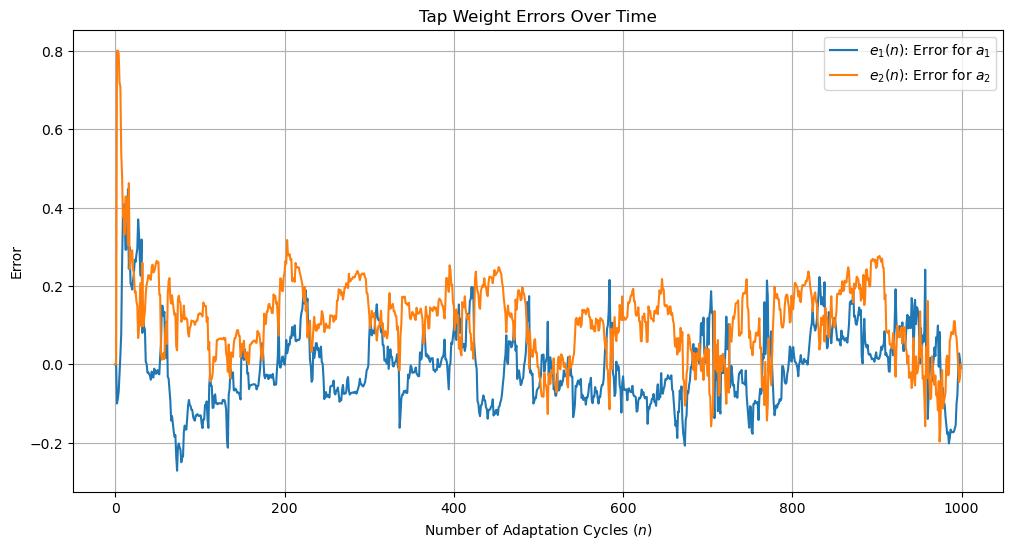

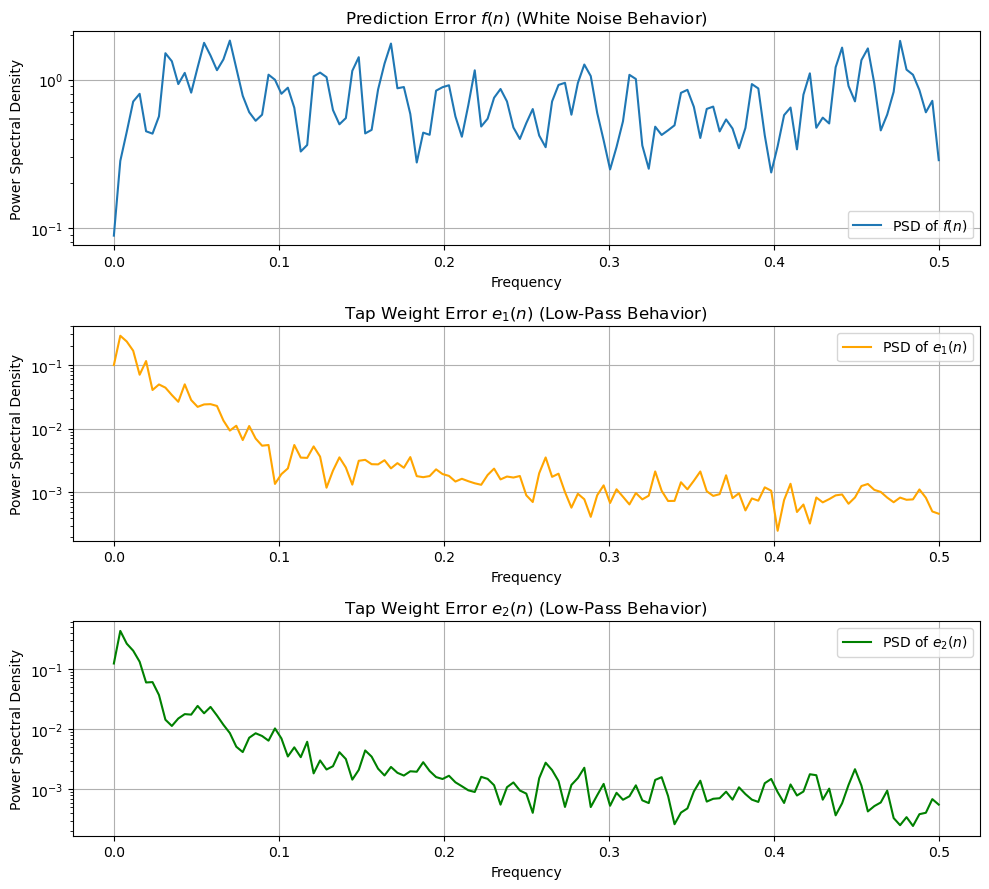

In [78]:
def compute_errors(u, w, a1, a2, num_samples):
    f = np.zeros(num_samples)
    e1 = np.zeros(num_samples)
    e2 = np.zeros(num_samples)
    for n in range(2, num_samples):
        x = np.array([u[n-1], u[n-2]])
        f[n] = u[n] - np.dot(w[n-1], x)  # prediction error
        e1[n] = -a1 - w[n, 0]  # tap-weight error for a1
        e2[n] = -a2 - w[n, 1]  # tap-weight error for a2
    return f, e1, e2

# Compute errors
f, e1, e2 = compute_errors(u, w, a1, a2, num_samples)

# Display final errors
print(f"Final prediction error (f[n]): {np.mean(f**2):.4f}")
print(f"Final tap-weight error for a1 (e1[n]): {e1[-1]:.4f}")
print(f"Final tap-weight error for a2 (e2[n]): {e2[-1]:.4f}")

# Plot tap-weight errors
plt.figure(figsize=(12, 6))
plt.plot(e1, label="$e_1(n)$: Error for $a_1$")
plt.plot(e2, label="$e_2(n)$: Error for $a_2$")
plt.title("Tap Weight Errors Over Time")
plt.xlabel("Number of Adaptation Cycles ($n$)")
plt.ylabel("Error")
plt.grid()
plt.legend()
plt.show()

def compute_psd(signal, fs=1.0):
    freqs, psd = welch(signal, fs=fs, nperseg=256)
    return freqs, psd

# PSD for f(n), e1(n), and e2(n)
freqs_f, psd_f = compute_psd(f)
freqs_e1, psd_e1 = compute_psd(e1)
freqs_e2, psd_e2 = compute_psd(e2)

# Plot psd
plt.figure(figsize=(10, 9))

# PSD of f(n)
plt.subplot(3, 1, 1)
plt.semilogy(freqs_f, psd_f, label="PSD of $f(n)$")
plt.title("Prediction Error $f(n)$ (White Noise Behavior)")
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.grid()
plt.legend()

# PSD of e1(n)
plt.subplot(3, 1, 2)
plt.semilogy(freqs_e1, psd_e1, label="PSD of $e_1(n)$", color="orange")
plt.title("Tap Weight Error $e_1(n)$ (Low-Pass Behavior)")
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.grid()
plt.legend()

# PSD of e2(n)
plt.subplot(3, 1, 3)
plt.semilogy(freqs_e2, psd_e2, label="PSD of $e_2(n)$", color="green")
plt.title("Tap Weight Error $e_2(n)$ (Low-Pass Behavior)")
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

### Part (d) and (e): Experimental and Theoretical Learning Curves

In this part, we compute and compare:
1. **Experimental Learning Curve**:
   - Obtained by averaging the squared prediction error $f(n)$ over an ensemble of 100 realizations of the AR(2) process.

2. **Theoretical Learning Curve**:
   - Computed using the small step-size theory:
     $$
     J(n) = \sigma_v^2 \left(1 + \frac{\mu}{2} \sigma_u^2 \right) + \sigma_u^2 \left(a_1^2 + a_2^2 - \frac{\mu}{2} \sigma_u^2 \right) \cdot (1 - \mu \sigma_u^2)^{2n},
     $$
     where:
     - $\sigma_v^2$: Noise variance,
     - $\sigma_u^2 = a_1^2 + a_2^2$: Variance of the AR process,
     - $\mu$: Step size,
     - $n$: Adaptation cycle index.

---

### Explanation of Results

1. **Theoretical Learning Curve**:
   - The red dashed line represents the theoretical learning curve derived from the small step-size theory.
   - It predicts the MSE behavior over adaptation cycles, including the transient and steady-state regions.

2. **Experimental Learning Curve**:
   - The blue line represents the ensemble-average MSE obtained from multiple realizations of the AR(2) process.
   - It illustrates the average performance of the LMS algorithm in estimating the AR parameters.

3. **Comparison**:
   - The experimental curve closely matches the theoretical curve, confirming the accuracy of the theoretical formula for small step sizes.
   - The steady-state region of the curves aligns, validating the predicted steady-state error derived from the theory.

---

### Observations
The agreement between the experimental and theoretical curves demonstrates:
1. The LMS algorithm adheres to the predictions of the small step-size statistical theory.
2. The steady-state error is consistent with the theoretical minimum mean-squared error $J_{\text{min}}$.

This validates the LMS algorithm's convergence properties and its accuracy in estimating the AR(2) process parameters.

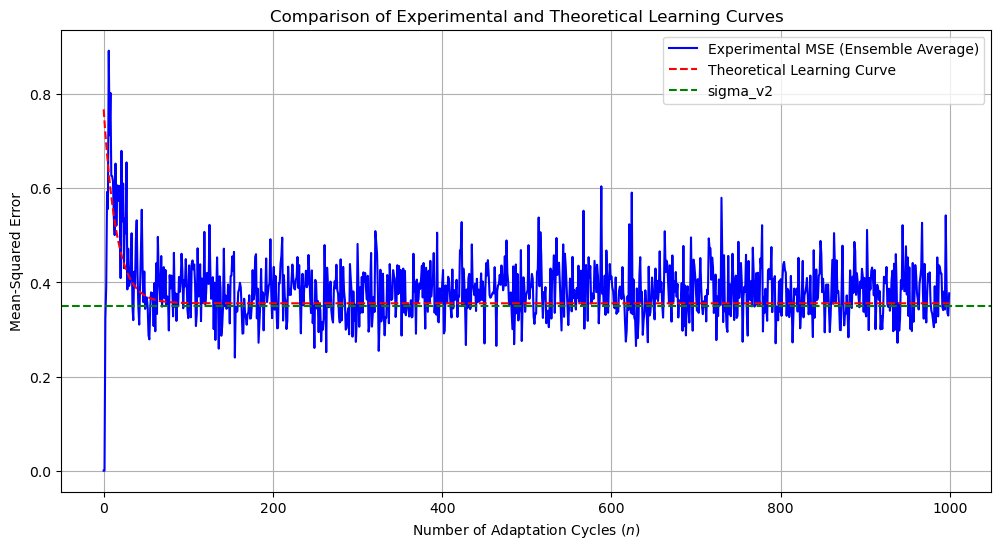

In [80]:
# compute theoretical learning curve
def theoretical_learning_curve(a1, a2, sigma_v2, miu, num_samples):
    sigma_u2 = a1**2 + a2**2  # variance of the AR process
    steady_state_mse = sigma_v2 * (1 + (miu / 2) * sigma_u2)
    transient_term = sigma_u2 * (a1**2 + a2**2 - (miu / 2) * sigma_u2)
    expo_decay = (1 - miu * sigma_u2)**(2 * np.arange(num_samples))
    J_theoretical = steady_state_mse + transient_term * expo_decay  # full learning curve
    return J_theoretical

# simulate experimental learning curve
num_realizations = 100  # number of realizations
squared_errors = np.zeros((num_realizations, num_samples))  # store squared errors

for realization in range(num_realizations):
    u_realization = generate_ar2(a1, a2, sigma_v2, num_samples)  # generate AR(2)
    _, f_realization = lms_ar2(u_realization, miu, num_samples)  # LMS algorithm
    squared_errors[realization, :] = f_realization**2  # store squared errors

ensemble_average_mse = np.mean(squared_errors, axis=0)  # average over realizations
theoretical_curve = theoretical_learning_curve(a1, a2, sigma_v2, miu, num_samples)

# Plot comparison of experimental and theoretical curves
plt.figure(figsize=(12, 6))
plt.plot(ensemble_average_mse, label="Experimental MSE (Ensemble Average)", color="blue")
plt.plot(theoretical_curve, label="Theoretical Learning Curve", linestyle="--", color="red")
plt.title(r"Comparison of Experimental and Theoretical Learning Curves")
plt.xlabel("Number of Adaptation Cycles ($n$)")
plt.ylabel("Mean-Squared Error")
plt.axhline(sigma_v2, color='g', linestyle='--', label="sigma_v2")
plt.grid()
plt.legend()
plt.show()